<a href="https://colab.research.google.com/github/gabbypaola/DATA604/blob/main/G_Martinez_chap16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 16

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# check if the libraries we need are installed

try:
    import pint
except ImportError:
    !pip install pint
    import pint
    
try:
    from modsim import *
except ImportError:
    !pip install modsimpy
    from modsim import *

## Code from previous notebooks

In [2]:
def update_func(state, t, system):
    """Update the thermal transfer model.
    
    state: State (temp)
    t: time
    system: System object
    
    returns: State (temp)
    """
    r, T_env, dt = system.r, system.T_env, system.dt
    
    T = state.T
    T += -r * (T - T_env) * dt
    
    return State(T=T)

In [3]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
    
    Add a TimeFrame to the System: results
    
    system: System object
    update_func: function that updates state
    """
    init = system.init
    t_0, t_end, dt = system.t_0, system.t_end, system.dt
    
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt)
    
    for t in ts:
        frame.row[t+dt] = update_func(frame.row[t], t, system)
    
    return frame

In [4]:
def make_system(T_init, r, volume, t_end):
    """Makes a System object with the given parameters.

    T_init: initial temperature in degC
    r: heat transfer rate, in 1/min
    volume: volume of liquid in mL
    t_end: end time of simulation
    
    returns: System object
    """
    init = State(T=T_init)
                   
    return System(init=init,
                  r=r, 
                  volume=volume,
                  temp=T_init,
                  t_0=0, 
                  t_end=t_end, 
                  dt=1,
                  T_env=22)

### Using `root_bisect`

As a simple example, let's find the roots of this function; that is, the values of `x` that make the result 0.

In [5]:
def func(x):
    return (x-1) * (x-2) * (x-3)

`modsim.py` provides `root_bisect`, which searches for a root by bisection.  The first argument is the function whose roots we want.  The second argument is an interval that contains a root.

In [6]:
res = root_bisect(func, [0.5, 1.5])

The result is an object that contains the root that was found and other information.

In [7]:
res.root

1.0

If we provide a different interval, we find a different root.

In [8]:
res = root_bisect(func, [1.5, 2.5])

In [9]:
res.root

2.0

If the interval doesn't contain a root, the results explain the error.

In [10]:
res = root_bisect(func, [4, 5])

In [11]:
res.root

AttributeError: ignored

Additional testing: when providing the interval with all roots, only the last root is provided. In this case, 3 is provided as the root.

In [12]:
res = root_bisect(func,[0.5,5.5])

In [13]:
res.root

3.0

We want to find the value of `r` that makes the final temperature 70, so we define an "error function" that takes `r` as a parameter and returns the difference between the final temperature and the goal.

In [14]:
def error_func1(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 70 C
    """
    system = make_system(T_init=90, r=r, volume=300, t_end=30)
    results = run_simulation(system, update_func)
    T_final = get_last_value(results.T)
    print(T_final - 70) #Exercise addition
    return T_final - 70

With `r=0.01`, we end up a little too warm.

In [15]:
error_func1(r=0.01)

2.2996253904030937


2.2996253904030937

With `r=0.02`, we end up too cold.

In [17]:
error_func1(r=0.02)

-10.907066281994297


-10.907066281994297

The return value from `root_bisect` is an array with a single element, the estimated value of `r`.

In [18]:
res = root_bisect(error_func1, [0.01, 0.02])

2.2996253904030937
-10.907066281994297
-4.788849694268251
-1.3746567918169745
0.4288111429787449
-0.48119275747843915
-0.028276637341065225
0.19974348477403225
0.08560277129113558
0.02863043999934689
0.00016874909731257048
-0.01405598161608168
-0.006944125703356008
-0.0033878156728093245
-0.0016095651312610926
-0.0007204159779803376
-0.00027583543057119186
-5.3543664193966833e-05
5.7602592164585076e-05
2.0294329203807138e-06
-2.57571234385523e-05
-1.1863847177551179e-05
-4.917207675703139e-06
-1.443887484242623e-06
2.9277265412019915e-07
-5.75557436377494e-07


In [19]:
r_coffee = res.root

In [20]:
r_coffee

0.011543084681034089

If we run the simulation with the estimated value of `r`, the final temperature is 70 C, as expected.

In [21]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final = get_last_value(results.T)

In [22]:
T_final

69.99999985860761

**Exercise:**  When you call `root_bisect`, it calls `error_func1` several times.  To see how this works, add a print statement to `error_func1` and run `root_bisect` again.

**Exercise:** Repeat this process to estimate `r_milk`, given that it starts at 5 C and reaches 20 C after 15 minutes.  

Before you use `root_bisect`, you might want to try a few values for `r_milk` and see how close you can get by trial and error.  Here's an initial guess to get you started:

The `r_milk` obtained via trial and error in chapter 15 was very close to the `r_milk` value obtained using the `root_bisect()` function. The trail and error value was correct to the 5th decimal.  

In [23]:
r_milk = 0.132961 # obtained from trial and error completed in chapter 15
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=15)
results = run_simulation(milk, update_func)
T_final = get_last_value(results.T)
T_final

20.00000728842391

In [24]:
# Solution goes here
def error_func2(r):
    """Runs a simulation and returns the `error`.
    
    r: heat transfer rate, in 1/min
    
    returns: difference between final temp and 20 C
    """
    system = make_system(T_init=5, r=r, volume=50, t_end=15)
    results = run_simulation(system, update_func)
    T_final = get_last_value(results.T)
    return T_final - 20

In [25]:
# Solution goes here
res = root_bisect(error_func2, [0.1, 0.2])

In [26]:
# Solution goes here
r_milk = res.root
r_milk

0.13296079039573666

### Mixing liquids

The following function takes `System` objects that represent two liquids, computes the temperature of the mixture, and returns a new `System` object that represents the mixture.

In [27]:
def mix(system1, system2):
    """Simulates the mixture of two liquids.
    
    system1: System representing coffee
    system2: System representing milk
    
    returns: System representing the mixture
    """
    assert system1.t_end == system2.t_end
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.temp, system2.temp
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       r=system1.r,
                       volume=V_mix,
                       t_end=30)

`mix` requires the `System` objects to have `temp` as a system variable.  `make_system` initializes this variable;
the following function makes sure it gets updated when we run a simulation.

In [28]:
def run_and_set(system):
    """Run a simulation and set the final temperature.
    
    system: System
    
    returns: TimeFrame
    """
    results = run_simulation(system, update_func)
    system.temp = get_last_value(results.T)
    return results

## Mixing immediately

Next here's what we get if we add the milk immediately.

In [29]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
coffee.temp

90

In [30]:
milk = make_system(T_init=5, r=r_milk, volume=50, t_end=30)
milk.temp

5

In [31]:
mix_first = mix(coffee, milk)
mix_first.temp

77.85714285714286

In [32]:
mix_results = run_and_set(mix_first)
mix_first.temp

61.4285713124277

## Mixing at the end

First we'll see what happens if we add the milk at the end.  We'll simulate the coffee and the milk separately.

In [33]:
coffee_results = run_and_set(coffee)
coffee.temp

69.99999985860761

In [34]:
milk_results = run_and_set(milk)
milk.temp

21.76470589082862

Here's what the results look like.

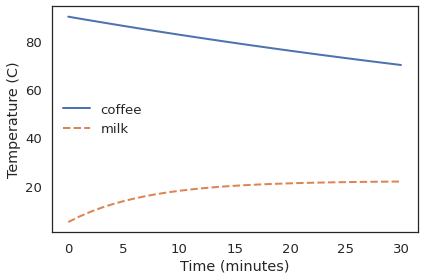

In [35]:
plot(coffee_results.T, label='coffee')
plot(milk_results.T, '--', label='milk')

decorate(xlabel='Time (minutes)',
         ylabel='Temperature (C)',
         loc='center left')



Here's what happens when we mix them.

In [36]:
mix_last = mix(coffee, milk)
mix_last.temp

63.10924357749633

In [37]:
mix_last.temp - mix_first.temp

1.6806722650686297

The following function takes `t_add`, which is the time when the milk is added, and returns the final temperature.

In [38]:
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    
    returns: final temperature
    """
    coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=t_add)
    coffee_results = run_and_set(coffee)
    
    milk = make_system(T_init=5, r=r_milk, volume=50, t_end=t_add)
    milk_results = run_and_set(milk)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_and_set(mixture)

    return mixture.temp

We can try it out with a few values.

In [39]:
run_and_mix(t_add=0, t_total=30)

61.4285713124277

In [40]:
run_and_mix(t_add=15, t_total=30)

62.9028090119359

In [41]:
run_and_mix(t_add=30, t_total=30)

63.10924357749633

And then sweep a range of values for `t_add`

In [42]:
sweep = SweepSeries()
for t_add in linspace(0, 30, 11):
    sweep[t_add] = run_and_mix(t_add, 30)

Here's what the result looks like.

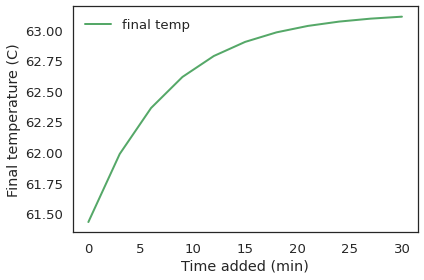

In [43]:
plot(sweep, label='final temp', color='C2')
decorate(xlabel='Time added (min)',
         ylabel='Final temperature (C)')



### Analysis

Now we can use the analytic result to compute temperature as a function of time.  The following function is similar to `run_simulation`.

In [44]:
def run_analysis(system):
    """Computes temperature using the analytic solution.
        
    system: System object
    
    returns: TimeFrame
    """
    T_env, r = system.T_env, system.r
    
    T_init = system.init.T    
    ts = linspace(0, system.t_end)
    
    T_array = T_env + (T_init - T_env) * exp(-r * ts)
    
    # to be consistent with run_simulation,
    # we put the array into a TimeFrame
    return TimeFrame(T_array, index=ts, columns=['T'])

Here's how we run it.  From the analysis (see `chap16sympy.ipynb`), we have the computed value of `r_coffee2`

In [45]:
r_coffee2 = 0.011610223142273859
coffee2 = make_system(T_init=90, r=r_coffee2, volume=300, t_end=30)

In [46]:
results = run_analysis(coffee2)
T_final_analysis = get_last_value(results.T)

And we can compare to the results from simulation.

In [47]:
coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end=30)
results = run_simulation(coffee, update_func)
T_final_simulation = get_last_value(results.T)

They are identical except for a small roundoff error.

In [48]:
T_final_analysis - T_final_simulation

1.4139239112864743e-07

## Exercises

**Exercise:**  Suppose the coffee shop won't let me take milk in a separate container, but I keep a bottle of milk in the refrigerator at my office.  In that case is it better to add the milk at the coffee shop, or wait until I get to the office?

Hint: Think about the simplest way to represent the behavior of a refrigerator in this model.  The change you make to test this variation of the problem should be very small!

1st attempt-
My first attempt which is the easiest way to account for milk that comes right out of the fridge would be to change the temperature `T_init` of the milk. 37F which is about 2.7C would be the temperature to change in `run_and_mix` and is as the hint suggests a very small adjustment. 

https://www.realsimple.com/food-recipes/shopping-storing/food/milk-storage-mistake#:~:text=Keep%20milk%20stored%20at%20the,begin%20to%20grow%20and%20multiply.

In [49]:
def mix(system1, system2):
    """Simulates the mixture of two liquids.
    
    system1: System representing coffee
    system2: System representing milk
    
    returns: System representing the mixture
    """
    assert system1.t_end == system2.t_end
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.temp, system2.temp
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       r=system1.r,
                       volume=V_mix,
                       t_end=30)

In [50]:
# Solution goes here
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    t_end: end time of simulation
    
    returns: final temperature
    """

    coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end= t_add)
    coffee_results = run_and_set(coffee)
    
    milk = make_system(T_init= 2.7, r=r_milk, volume=50, t_end=t_add)
    milk_results = run_and_set(milk)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_and_set(mixture)

    return mixture.temp

In [51]:
run_and_mix(t_add=15, t_total=30)

62.87033192826685

2nd attempt- My second attempt is as a result of me thinking more about the problem and probably goes beyond the hint's suggestion. The second attempt includes a manipulation of the `t_end` variables for milk and coffee in `run_and_mix` which also requires an edit to the `mix` function. 
This could potentially be a better way of accounting for adding refrigerated milk after getting to work because there is a time element to account for from getting the coffee at the shop and then adding the milk once you get to work. In the time the coffee leaves the store, it is already entering the cooling process.


In [52]:
def mix(system1, system2):
    """Simulates the mixture of two liquids.
    
    system1: System representing coffee
    system2: System representing milk
    
    returns: System representing the mixture
    """
    #assert system1.t_end == system2.t_end
    
    V1, V2 = system1.volume, system2.volume
    T1, T2 = system1.temp, system2.temp
    
    V_mix = V1 + V2
    T_mix = (V1 * T1 + V2 * T2) / V_mix
    
    return make_system(T_init=T_mix,
                       r=system1.r,
                       volume=V_mix,
                       t_end=30)

In [53]:
# Solution goes here
def run_and_mix(t_add, t_total):
    """Simulates two liquids and them mixes them at t_add.
    
    t_add: time in minutes
    t_total: total time to simulate, min
    t_end: end time of simulation
    
    returns: final temperature
    """

    coffee = make_system(T_init=90, r=r_coffee, volume=300, t_end= t_total)
    coffee_results = run_and_set(coffee)
    
    milk = make_system(T_init=5, r=r_milk, volume=50, t_end=t_add)
    milk_results = run_and_set(milk)
    
    mixture = mix(coffee, milk)
    mixture.t_end = t_total - t_add
    results = run_and_set(mixture)

    return mixture.temp

In [54]:
run_and_mix(t_add=15, t_total=30)

56.32686591182933